In [115]:
import pandas as pd
from sqlalchemy import create_engine
from joblib import Parallel, delayed
from tqdm import tqdm
from hurst import compute_Hc
import plotly.express as px
import seaborn as sns

import pandas as pd
import numpy as np
import vectorbt as vbt
import glob
import os
import scipy.stats as stats



import warnings 
warnings.filterwarnings('ignore')


In [3]:
DATA_DIR = 'data/'

fx_list = ['EURCZK', 'AUDUSD', 'EURHUF', 'EURNOK', 'EURPLN',
           'EURSEK', 'EURUSD', 'GBPUSD', 'NZDUSD', 'USDCAD',
           'USDCHF', 'USDCNH', 'USDILS', 'USDJPY', 'USDMXN', 
           'USDSGD', 'USDZAR']

In [77]:
def preprocessing_data(path):
    if 'futures_1min_bar' in path:
        data = pd.read_parquet(path)
        data = data.sort_values(by='timestamp')
        data['Roll Adjusted Bid'] = data['bid'] + data['adjustment']
        data['Roll Adjusted Offer'] = data['offer'] + data['adjustment']
        data['mid_price'] = (data['Roll Adjusted Bid'] + data['Roll Adjusted Offer']) / 2
    else:
        data = pd.read_parquet(path)
        data = data.sort_values(by='timestamp')
        data['mid_price'] = (data['bid'] + data['offer']) / 2

    return data.set_index('timestamp').ffill().dropna()

In [ ]:
hurst_df = []

for path in tqdm(glob.glob('data/*.parquet')):
    cur_data = preprocessing_data(path)
    hurst_value, _, _ = compute_Hc(cur_data['mid_price'], kind='price', simplified=True)
    hurst_df.append([path.split('.')[0].split('/')[-1], hurst_value])

hurst_df = pd.DataFrame(hurst_df, columns = ['data', 'hurst_value'])
hurst_df

100%|██████████| 18/18 [01:10<00:00,  3.90s/it]


,data,hurst_value
0,USDCHF_data,0.490713
1,USDILS_data,0.472870
2,EURSEK_data,0.443851
3,AUDUSD_data,0.480182
4,USDMXN_data,0.482525
5,EURHUF_data,0.484386
6,USDCNH_data,0.500666
7,USDJPY_data,0.534108
8,EURNOK_data,0.443485
9,NZDUSD_data,0.452005


In [80]:
hurst_df.to_csv('data/results/hurst_data.csv', index=False)

In [79]:
px.bar(
    hurst_df.sort_values(by='hurst_value'),
    x='hurst_value',
    y='data'
)

In [87]:
def bootstrap_hurst(series, n_iter=100, sample_frac=0.6, n_jobs=-1):
    series = np.asarray(series)
    n = len(series)
    sample_size = int(n * sample_frac)

    # Внутренняя функция для одной итерации
    def one_bootstrap():
        idx = np.random.choice(n, size=sample_size, replace=False)
        sample = series[np.sort(idx)]
        H, _, _ = compute_Hc(sample, kind='price', simplified=False)
        return H

    # Параллельное выполнение
    hurst_vals = Parallel(n_jobs=n_jobs)(
        delayed(one_bootstrap)() for _ in tqdm(range(n_iter), desc='Bootstaping...')
    )

    return np.percentile(hurst_vals, [2.5, 97.5]), np.mean(hurst_vals)

In [91]:
hurst_df_ci = []


for path in glob.glob('data/*.parquet'):
    data_label = path.split('.')[0].split('/')[-1]
    cur_data = preprocessing_data(path)
    ci, mean_hurst = bootstrap_hurst(cur_data['mid_price'].dropna().values)
    
    hurst_df_ci.append([data_label, mean_hurst, ci[0], ci[1]])

hurst_df_ci = pd.DataFrame(hurst_df_ci, columns=['data', 'hurst_value', 'ci_low', 'ci_high'])
hurst_df_ci

Bootstaping...: 100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


,data,hurst_value,ci_low,ci_high
0,USDCHF_data,0.507103,0.504666,0.509778
1,USDILS_data,0.462270,0.455389,0.468509
2,EURSEK_data,0.449087,0.447195,0.451716
3,AUDUSD_data,0.490828,0.488110,0.494015
4,USDMXN_data,0.477746,0.474204,0.482011
5,EURHUF_data,0.484000,0.482715,0.485699
6,USDCNH_data,0.505916,0.502549,0.514167
7,USDJPY_data,0.520156,0.516257,0.525028
8,EURNOK_data,0.446753,0.443789,0.449752
9,NZDUSD_data,0.465292,0.461110,0.470269


In [93]:
px.bar(
    hurst_df_ci.sort_values(by='hurst_value'),
    x='hurst_value',
    y='data',
    error_x=hurst_df_ci['ci_high'] - hurst_df_ci['hurst_value'],
    error_x_minus=hurst_df_ci['hurst_value'] - hurst_df_ci['ci_low'],
    title='Hurst Exponent with 95% Confidence Intervals'
)

In [94]:
hurst_df_ci.to_csv('data/results/hurst_ci_data.csv', index=False)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculate_variance_ratio(returns, q_max=20):
    """
    Расчет VR(q) для лагов от 2 до q_max.
    :param returns: np.array — лог-доходности
    :param q_max: максимальный лаг q
    :return: DataFrame c колонками q и VR(q)
    """
    vr_values = []
    for q in range(2, q_max + 1):
        weighted_sum = 0
        for k in range(1, q):
            weight = 1 - k / q
            corr = np.corrcoef(returns[:-k], returns[k:])[0, 1]
            weighted_sum += weight * corr
        vr_q = 1 + 2 * weighted_sum
        vr_values.append((q, vr_q))
    return pd.DataFrame(vr_values, columns=["q", "VR"])


def plot_vr_for_assets(asset_dict, q_max=20):
    """
    Построение VR-графиков для нескольких активов.
    :param asset_dict: словарь вида {'ES': prices_ES, 'EURUSD': prices_eur, ...}
    """
    plt.figure(figsize=(12, 6))
    for name, price_series in tqdm(asset_dict.items()):
        returns = np.diff(np.log(price_series))
        vr_df = calculate_variance_ratio(returns, q_max=q_max)
        plt.plot(vr_df['q'], vr_df['VR'], label=name)

    plt.axhline(1.0, color='gray', linestyle='--', label='Random Walk')
    plt.xlabel("Lag q")
    plt.ylabel("Variance Ratio")
    plt.title("Variance Ratio vs Lag q")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_vr_for_assets(asset_prices, q_max=100)

In [97]:
def plot_vr_for_assets(asset_dict, q_max=20):
    """
    Построение VR-графиков для нескольких активов.
    :param asset_dict: словарь вида {'ES': prices_ES, 'EURUSD': prices_eur, ...}
    """
    plt.figure(figsize=(12, 6))
    for name, price_series in tqdm(asset_dict.items()):
        returns = np.diff(np.log(price_series))
        vr_df = calculate_variance_ratio(returns, q_max=q_max)
        plt.plot(vr_df['q'], vr_df['VR'], label=name)

    plt.axhline(1.0, color='gray', linestyle='--', label='Random Walk')
    plt.xlabel("Lag q")
    plt.ylabel("Variance Ratio")
    plt.title("Variance Ratio vs Lag q")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [101]:
asset_prices = {}

for path in tqdm(glob.glob('data/*.parquet')):
    data_label = path.split('.')[0].split('/')[-1]
    cur_data = preprocessing_data(path)
    asset_prices[data_label] = cur_data['mid_price'].dropna().values

100%|██████████| 18/18 [00:04<00:00,  3.65it/s]


In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

def calculate_variance_ratio(returns, q_max=20):
    vr_values = []
    for q in range(2, q_max + 1):
        weighted_sum = 0
        for k in range(1, q):
            weight = 1 - k / q
            corr = np.corrcoef(returns[:-k], returns[k:])[0, 1]
            weighted_sum += weight * corr
        vr_q = 1 + 2 * weighted_sum
        vr_values.append((q, vr_q))
    return pd.DataFrame(vr_values, columns=["q", "VR"])


def calculate_vr_for_asset(name, price_series, q_max=20):
    returns = np.diff(np.log(price_series))
    vr_df = calculate_variance_ratio(returns, q_max=q_max)
    vr_df["asset"] = name
    return vr_df


def run_parallel_vr(asset_dict, q_max=20, max_workers=4):
    all_results = []

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(calculate_vr_for_asset, name, prices, q_max): name
            for name, prices in asset_dict.items()
        }

        for future in tqdm(as_completed(futures), total=len(futures), desc="Calculating VR"):
            result = future.result()
            all_results.append(result)

    return pd.concat(all_results, ignore_index=True)


def plot_vr(df):
    plt.figure(figsize=(12, 6))
    for asset in df['asset'].unique():
        sub = df[df['asset'] == asset]
        plt.plot(sub['q'], sub['VR'], label=asset)

    plt.axhline(1.0, color='gray', linestyle='--', label='Random Walk')
    plt.xlabel("Lag q")
    plt.ylabel("Variance Ratio")
    plt.title("Variance Ratio vs Lag q")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Bootstaping...:  95%|█████████▌| 95/100 [34:31<01:49, 21.80s/it]


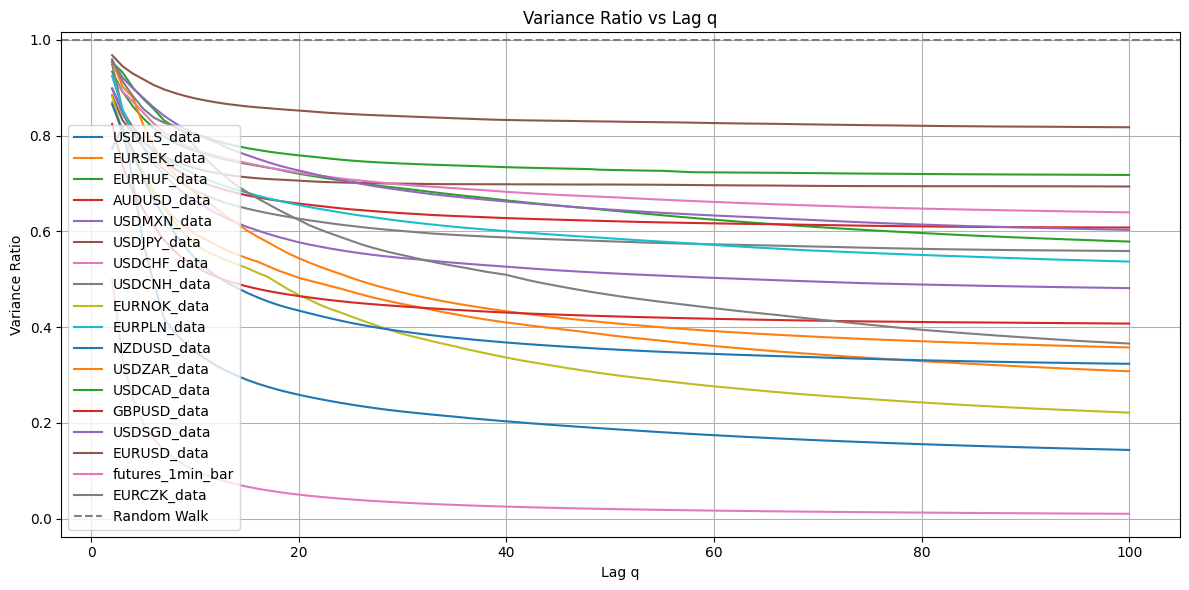

In [105]:
vr_result = run_parallel_vr(asset_prices, q_max=100, max_workers=8)
plot_vr(vr_result)

In [109]:
vr_result.to_parquet('data/results/anrew_lo_test.parquet')

In [131]:
vr_result

,q,VR,asset
0,2,0.772320,USDILS_data
1,3,0.819416,USDILS_data
2,4,0.705636,USDILS_data
3,5,0.573490,USDILS_data
4,6,0.494208,USDILS_data
...,...,...,...
1777,96,0.370192,EURCZK_data
1778,97,0.369088,EURCZK_data
1779,98,0.367976,EURCZK_data
1780,99,0.366843,EURCZK_data


In [ ]:
def correlation_table(prices, lookbacks, holds, log_return: bool = False):
    res = []
    for lb in lookbacks:
        for hold in holds:
            step = hold if lb >= hold else lb

            if log_return:
                lb_returns = np.log(prices[lb:-hold:step] / prices[:-lb-hold:step])
                hold_returns = np.log(prices[lb+hold::step] / prices[lb:-hold:step])
            else:
                lb_returns = (prices[lb:-hold:step] - prices[:-lb-hold:step]) / prices[:-lb-hold:step]
                hold_returns = (prices[lb+hold::step] - prices[lb:-hold:step]) / prices[lb:-hold:step]

            mask = ~np.isnan(lb_returns) & ~np.isnan(hold_returns)
            nans_ratio = 1. - mask.sum() / lb_returns.shape[0]
            assert nans_ratio <= 1e-4 and mask.sum() > 10, (nans_ratio, mask.sum())

            corr, pval_2_sided = stats.pearsonr(lb_returns, hold_returns, alternative='two-sided')
            _, pval_less = stats.pearsonr(lb_returns, hold_returns, alternative='less')
            _, pval_greater = stats.pearsonr(lb_returns, hold_returns, alternative='greater')
            safe_pval = max(pval_2_sided, 1e-6)
            score = abs(corr / safe_pval)
            res.append([lb, hold, corr, abs(corr), pval_2_sided, score, pval_less, pval_greater])

    return pd.DataFrame(res, columns=[
        'LookBack', 'Hold', 'Pearson corr', 'Abs(corr)', 'P-value (two-sided)',
        'Abs(corr / p_value (H1: corr!=0))', 'P-value (H1: corr < 0)', 'P-value (H1: corr > 0)'])



In [127]:
correlation_df = []

for path in tqdm(glob.glob('data/*.parquet')):
    data_label = path.split('.')[0].split('/')[-1]
    cur_data = preprocessing_data(path)
    returns_table = correlation_table(cur_data['mid_price'].dropna().values, 
                                  lookbacks=range(5,61,1), 
                                  holds=range(5,61,1))
    returns_table['data'] = data_label

    correlation_df.append(returns_table)

100%|██████████| 18/18 [02:28<00:00,  8.25s/it]


In [130]:
pd.concat(correlation_df).to_parquet('data/results/correlation_table.parquet')

In [133]:
pd.concat(correlation_df)

,LookBack,Hold,Pearson corr,Abs(corr),P-value (two-sided),Abs(corr / p_value (H1: corr!=0)),P-value (H1: corr < 0),P-value (H1: corr > 0),data
0,5,5,-0.089865,0.089865,0.000000e+00,89865.296752,0.000000e+00,1.0,USDCHF_data
1,5,6,-0.092220,0.092220,0.000000e+00,92219.570827,0.000000e+00,1.0,USDCHF_data
2,5,7,-0.084502,0.084502,0.000000e+00,84502.293699,0.000000e+00,1.0,USDCHF_data
3,5,8,-0.072670,0.072670,6.277031e-273,72669.866782,3.138516e-273,1.0,USDCHF_data
4,5,9,-0.073373,0.073373,3.281152e-278,73373.465322,1.640576e-278,1.0,USDCHF_data
...,...,...,...,...,...,...,...,...,...
3131,60,56,-0.214663,0.214663,6.698306e-213,214662.983457,3.349153e-213,1.0,EURCZK_data
3132,60,57,-0.149265,0.149265,5.694919e-101,149264.885233,2.847459e-101,1.0,EURCZK_data
3133,60,58,-0.203911,0.203911,2.544992e-185,203910.589537,1.272496e-185,1.0,EURCZK_data
3134,60,59,-0.215544,0.215544,7.201679e-204,215543.638252,3.600840e-204,1.0,EURCZK_data


In [118]:
cur_data['mid_price'].min()

np.float64(23.05713)

In [179]:
def run_strategy(df, X, slippage):
    df = df.copy()
    
    long_signal = (entry_prices['ret'] > X)
    short_signal = (entry_prices['ret'] < -X)
    
    df['entry_long'] = False
    df['entry_short'] = False
    df['exit'] = False
    
    df.loc[entry_prices[long_signal].index, 'entry_long'] = True
    df.loc[entry_prices[short_signal].index, 'entry_short'] = True
    df.loc[exit_prices.index, 'exit'] = True

    entries = df['entry_long']
    short_entries = df['entry_short']
    exits = df['exit']

    size = 1

    portfolio = vbt.Portfolio.from_signals(
        close=df['price'],
        entries=entries,
        short_entries=short_entries,
        exits=exits,
        short_exits=exits,
        size=size,
        size_type = 'amount',
        slippage = slippage,
        # sl_stop=0.001,
        # sl_stop=0.0001,   # stop-loss        
        # tp_stop=0.0001,   # take profit
        freq='1T'
    )

    return portfolio


fname = f"{DATA_DIR}futures_1min_bar.parquet"
df = preprocessing_data(fname)

df['price'] = (df['bid'] + df['offer']) / 2
df['date'] = df.index.floor('D')

grouped = df.groupby('date')
prev_close = grouped['price'].last().shift(1)


entry_price_time = pd.to_datetime("23:00:00").time()
exit_price_time = pd.to_datetime("23:59:00").time()

entry_mask = df.index.time == entry_price_time
exit_mask = df.index.time == exit_price_time

entry_prices = df[entry_mask].copy()
exit_prices = df[exit_mask].copy()

entry_prices['prev_close'] = entry_prices['date'].map(prev_close)
entry_prices['ret'] = (entry_prices['price'] - entry_prices['prev_close']) / entry_prices['prev_close']

In [180]:
np.arange(0.001, 0.02, 0.001).shape, np.arange(0.005, 0.05, 0.001).shape

((19,), (46,))

In [181]:
import numpy as np
import itertools

# Параметры подбора
X_values = np.arange(0.005, 0.05, 0.001)    
slippage_values = np.arange(0.001, 0.02, 0.001) 

results = []

for X_val, sl_val in tqdm(itertools.product(X_values, slippage_values)):
    pf = run_strategy(df, X=X_val, slippage=sl_val)
    stats = pf.stats()
    results.append({
        'X': X_val,
        'slippage_usd': sl_val,
        'total_return': stats['Total Return [%]'],
        'sharpe': stats['Sharpe Ratio'],
        'drawdown': stats['Max Drawdown [%]']
    })

results_df = pd.DataFrame(results)
print(results_df.sort_values(by='total_return', ascending=False))


874it [00:55, 15.67it/s]

         X  slippage_usd  total_return    sharpe    drawdown
209  0.016         0.001    200.342084  1.983969   73.453620
190  0.015         0.001    199.870558  1.982184   73.453620
342  0.023         0.001    199.056000  2.237067   50.843141
361  0.024         0.001    199.056000  2.237067   50.843141
323  0.022         0.001    199.056000  2.237067   50.843141
..     ...           ...           ...       ...         ...
189  0.014         0.019   -271.826005 -1.296072  275.497851
132  0.011         0.019   -279.882457 -1.297509  283.726465
113  0.010         0.019   -279.882457 -1.297509  283.726465
94   0.009         0.019   -283.213693 -1.296570  287.128888
75   0.008         0.019   -283.213693 -1.296570  287.128888

[874 rows x 5 columns]


In [182]:
fig_3d = px.scatter_3d(
    results_df,
    x="X",
    y="slippage_usd",
    z="total_return",
    color="sharpe",
    title="3D визуализация бектестинга",
    height=600,
    hover_data=['drawdown']
)

fig_3d.show()

In [160]:
results_df.to_parquet('data/results/backtesting0.parquet')

In [184]:
def run_strategy_with_st_tp(df, X, 
                            sl_stop=sl_stop,
                            tp_stop = tp_stop
                            ):
    df = df.copy()
    
    long_signal = (entry_prices['ret'] > X)
    short_signal = (entry_prices['ret'] < -X)
    
    df['entry_long'] = False
    df['entry_short'] = False
    df['exit'] = False
    
    df.loc[entry_prices[long_signal].index, 'entry_long'] = True
    df.loc[entry_prices[short_signal].index, 'entry_short'] = True
    df.loc[exit_prices.index, 'exit'] = True

    entries = df['entry_long']
    short_entries = df['entry_short']
    exits = df['exit']

    size = 1

    portfolio = vbt.Portfolio.from_signals(
        close=df['price'],
        entries=entries,
        short_entries=short_entries,
        exits=exits,
        short_exits=exits,
        size=size,
        size_type = 'amount',
        sl_stop=sl_stop,   # stop-loss        
        tp_stop=tp_stop,   # take profit
        freq='1T'
    )

    return portfolio


fname = f"{DATA_DIR}futures_1min_bar.parquet"
df = preprocessing_data(fname)

df['price'] = (df['bid'] + df['offer']) / 2
df['date'] = df.index.floor('D')

grouped = df.groupby('date')
prev_close = grouped['price'].last().shift(1)


entry_price_time = pd.to_datetime("23:00:00").time()
exit_price_time = pd.to_datetime("23:59:00").time()

entry_mask = df.index.time == entry_price_time
exit_mask = df.index.time == exit_price_time

entry_prices = df[entry_mask].copy()
exit_prices = df[exit_mask].copy()

entry_prices['prev_close'] = entry_prices['date'].map(prev_close)
entry_prices['ret'] = (entry_prices['price'] - entry_prices['prev_close']) / entry_prices['prev_close']

In [ ]:
import numpy as np
import itertools

# Параметры подбора
X_values = np.arange(0.005, 0.05, 0.001)    
sp_values = np.arange(0.005, 0.05, 0.001)    
# tp_values = np.arange(0.005, 0.1, 0.01)    

results = []

for X_val, sl_stop in tqdm(itertools.product(X_values, sp_values)):
    pf = run_strategy_with_st_tp(df, X=X_val, sl_stop=sl_stop)
    stats = pf.stats()
    results.append({
        'X': X_val,
        # 'slippage_usd': sl_val,
        'sl_stop': sl_stop,
        # 'tp_stop': tp_stop,
        'total_return': stats['Total Return [%]'],
        'sharpe': stats['Sharpe Ratio'],
        'drawdown': stats['Max Drawdown [%]']
    })

# В датафрейм для удобного анализа
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='total_return', ascending=False))


777it [00:49, 16.73it/s]

In [176]:
results_df['total_return'].max()

np.float64(0.007850000000000135)

In [178]:
fig_3d = px.scatter_3d(
    results_df,
    x="X",
    y="sl_stop",
    z="sharpe",
    color="total_return",
    title="3D визуализация бектестинга",
    height=600,
    hover_data=['drawdown']
)

fig_3d.show()

,0
2023-12-01 00:01:00,2023-12-01 00:01:00
2023-12-01 00:02:00,2023-12-01 00:02:00
2023-12-01 00:03:00,2023-12-01 00:03:00
2023-12-01 00:04:00,2023-12-01 00:04:00
2023-12-01 00:05:00,2023-12-01 00:05:00
...,...
2025-02-24 17:28:00,2025-02-24 17:28:00
2025-02-24 17:29:00,2025-02-24 17:29:00
2025-02-24 17:30:00,2025-02-24 17:30:00
2025-02-24 17:31:00,2025-02-24 17:31:00


In [8]:
future_df = pd.read_parquet(DATA_DIR+f'futures_1min_bar.parquet')

future_df = future_df.sort_values(by='timestamp')
future_df

,contract,instrument,bid,offer,bid_size,offer_size,timestamp,adjustment
0,ES,ESZ3,4572.75,4573.00,21,31,2023-12-01 00:01:00,316.375
1,ES,ESZ3,4572.50,4572.75,31,23,2023-12-01 00:02:00,316.375
2,ES,ESZ3,4571.75,4572.00,69,20,2023-12-01 00:03:00,316.375
3,ES,ESZ3,4571.75,4572.00,67,21,2023-12-01 00:04:00,316.375
4,ES,ESZ3,4571.75,4572.00,24,47,2023-12-01 00:05:00,316.375
...,...,...,...,...,...,...,...,...
312818,ES,ESH5,6043.25,6043.50,15,24,2025-02-24 17:27:00,0.000
312819,ES,ESH5,6043.25,6043.50,13,32,2025-02-24 17:28:00,0.000
312820,ES,ESH5,6042.00,6042.25,13,41,2025-02-24 17:29:00,0.000
312821,ES,ESH5,6040.00,6040.25,21,32,2025-02-24 17:30:00,0.000


In [4]:
future_df = pd.read_parquet(DATA_DIR+f'futures_1min_bar.parquet')

future_df = future_df.sort_values(by='timestamp')
future_df = future_df[~future_df.bid.isna()]
future_df['Roll Adjusted Bid'] = future_df['bid'] + future_df['adjustment']
future_df['Roll Adjusted Offer'] = future_df['offer'] + future_df['adjustment']
future_df['mid_price'] = (future_df['Roll Adjusted Bid'] + future_df['Roll Adjusted Offer']) / 2
print(future_df.shape)
future_df.head(2)

(312822, 11)


,contract,instrument,bid,offer,bid_size,offer_size,timestamp,adjustment,Roll Adjusted Bid,Roll Adjusted Offer,mid_price
0,ES,ESZ3,4572.75,4573.00,21,31,2023-12-01 00:01:00,316.375,4889.125,4889.375,4889.25
1,ES,ESZ3,4572.50,4572.75,31,23,2023-12-01 00:02:00,316.375,4888.875,4889.125,4889.00


In [5]:
hurst_df = [['feature', compute_Hc(future_df['mid_price'], kind='price', simplified=False)[0]]]

for fx in tqdm(fx_list):
    cur_data = pd.read_parquet(DATA_DIR+f'{fx}_data.parquet')
    cur_data['mid_price'] = (cur_data['bid'] + cur_data['offer'])/2
    cur_data = cur_data[~cur_data.mid_price.isna()].sort_values(by='timestamp')
    hurst_value, _, _ = compute_Hc(cur_data['mid_price'], kind='price', simplified=True)

    hurst_df.append([fx, hurst_value])

hurst_df = pd.DataFrame(hurst_df, columns = ['data', 'hurst_value'])

px.bar(
    hurst_df.sort_values(by='hurst_value'),
    x='hurst_value',
    y='data'
)

100%|██████████| 17/17 [01:02<00:00,  3.69s/it]
